In [3]:
import pandas as pd 
import pandahouse
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import swifter
from scipy import stats

In [4]:
connection = {
'host': 'https://clickhouse.lab.karpov.courses', 'password': 'dpo_python_2020',
'user': 'student',
'database': 'simulator_20250120' }

In [7]:
q = """
SELECT exp_group,
user_id,
sum(action = 'like') as likes, 
sum(action = 'view') as views, 
likes/views as ctr
FROM simulator_20250120.feed_actions
WHERE toDate(time) between '2025-01-03' and '2025-01-09' and exp_group in (1,2)
GROUP BY exp_group, user_id """
df = pandahouse.read_clickhouse(q, connection=connection) 
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10020,10020,10020,10020
2,9877,9877,9877,9877


In [10]:
sns.set(rc={'figure.figsize':(12.5,8.27)})

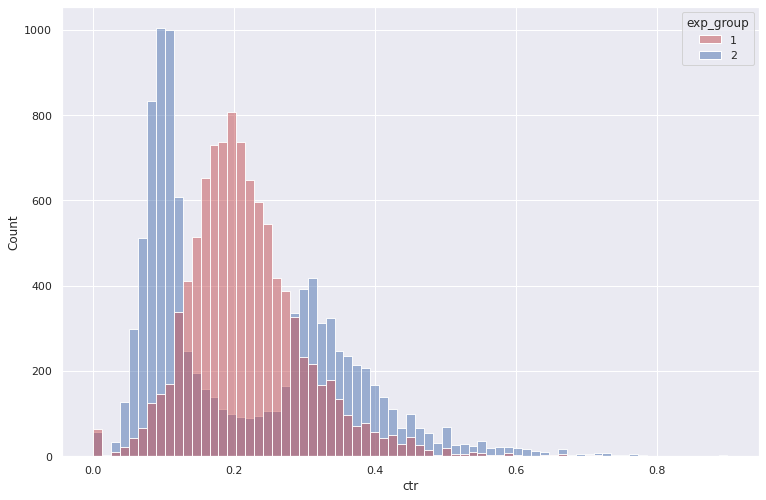

In [11]:
groups = sns.histplot(data = df,
x='ctr',
hue='exp_group', 
palette = ['r', 'b'],
alpha=0.5, 
kde=False)

In [ ]:
На графике мы видим, что у наших групп совершенно непохожие распределения. Если для группы 1 одно нормальное, то группа 2 имеет бимодальное распределение.
Т.е. испытанная система рекомендаций разделяет пользователей на две выраженные группы: для одной большой группы она снижает CTR (эта часть пользователей не любит повторяющийся контент, например),
а для другой, наоборот, повышает (эти пользователи любят лайкать одно и то же).

In [63]:
Проведем T-test:

In [37]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr, 
                equal_var=False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

In [ ]:
Результат Т-теста не ползволяет отклонить нулевую гипотезу, т.к. p-value больше 0.05.
Но применение Т-теста при таком распределении не совсем корректно, т.к. тут мы сравниваем средние значения в двух выборках.

In [ ]:
Проведем тест Манна-Уитни:

In [14]:
print(stats.mannwhitneyu(df[df.exp_group == 1].ctr,
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided'))

print('Отличие не прокрасилось')

A_gt_B = 0
for _ in range(10000):
    A_gt_B+= df[df.exp_group == 1].ctr.sample().values[0] > df[df.exp_group == 2].ctr.sample().values[0]

print('В', A_gt_B/100, '% случаев A > B. Должно получиться около 50%')

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)
Отличие не прокрасилось
В 55.68 % случаев A > B. Должно получиться около 50%


In [ ]:
Тут мы видим, что по тесту Манна-Уитни статистически значимые различия есть. Но результат теста показывает, что CTR в контрольной группе больше, чем в тестовой, а это не тот эффект, который
ожидался от новой системы рекомендаций.

## Проведем T-test на сглаженом CTR

In [23]:
# Функция для расчета сглаженного CTR
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

# Считаем общегрупповой CTR для каждой группы
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

In [34]:
# Считаем сглаженный CTR для первой группы
group1 = df[df.exp_group == 1].copy()
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

In [35]:
# Считаем сглаженный CTR для второй группы
group2 = df[df.exp_group == 2].copy()
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

In [ ]:
Смотрим как на графике выглядят группы со сглаженным CTR

<Axes: xlabel='smothed_ctr', ylabel='Count'>

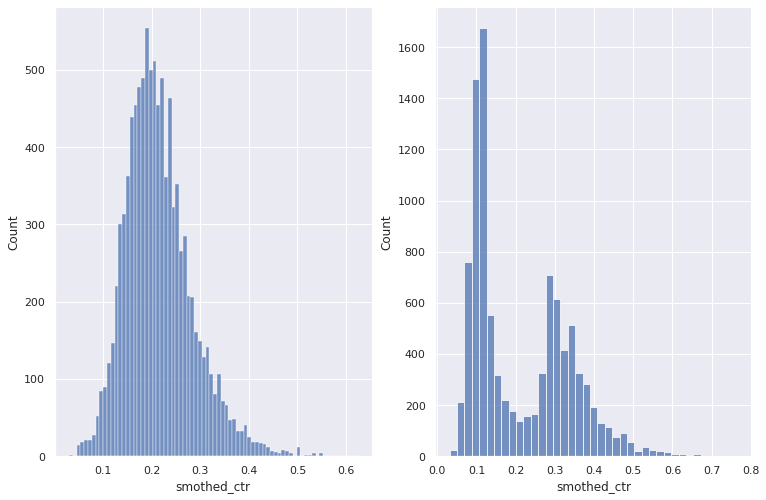

In [36]:
plt.subplot(1, 2, 1)
sns.histplot(group1.smothed_ctr, 
             kde = False)
plt.subplot(1, 2, 2)
sns.histplot(group2.smothed_ctr, 
             kde = False)

In [ ]:
Применим T-test на сглаженный CTR

In [39]:
stats.ttest_ind(group1['smothed_ctr'],
                group2['smothed_ctr'],
                equal_var=False)

Ttest_indResult(statistic=1.9460491517027683, pvalue=0.05166679015318526)

In [ ]:
Резутьтаты этого Т-теста показывают p-value уже меньше, чем в первоначальном расчете на обычном CTR, чуть больше 0.05.
Но мы все еще не можем отклонить нулевую гипотезу и утверждать, что в тестовой группе CTR вырос от новой системы рекомендаций.

In [ ]:
И проведем тест Манна-Уитни сглаженном CTR

In [40]:
stats.mannwhitneyu(group1.smothed_ctr,
                   group2.smothed_ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=55528353.0, pvalue=2.396534039374286e-50)

In [41]:
A_gt_B = 0
for _ in range(10000):
    A_gt_B+= group1.smothed_ctr.sample().values[0] > group2.smothed_ctr.sample().values[0]
    
print('В', A_gt_B/100, '% случаев A > B. Должно получиться около 50%')

В 56.39 % случаев A > B. Должно получиться около 50%


In [ ]:
Тест Манна-Уитни повторяет резутьтаты расчета на обычном CTR.
P-value уменьшился, но все еще говорит нам от том, что статистически значимые разлиция есть и также показывает, что CTR в контрольной группе выше, чем в тестовой.

## Пуассоновский бутстреп для подсчета разницы в CTR

In [44]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    
    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes2))).astype(np.int64)

    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

<Axes: ylabel='Count'>

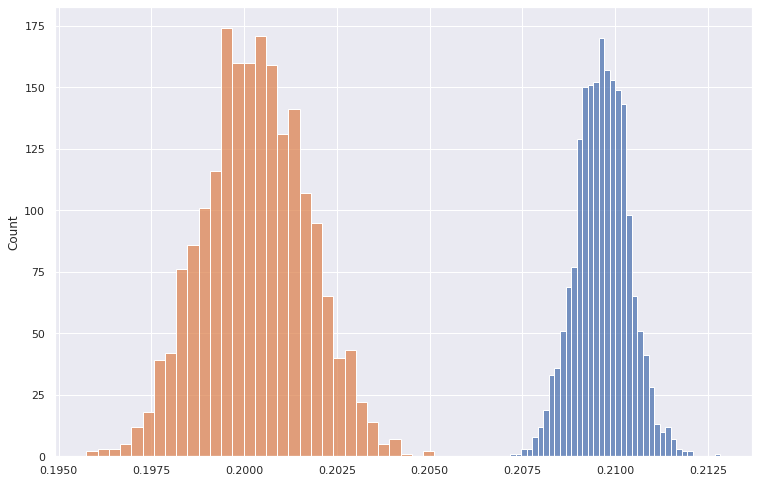

In [45]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)

<Axes: ylabel='Count'>

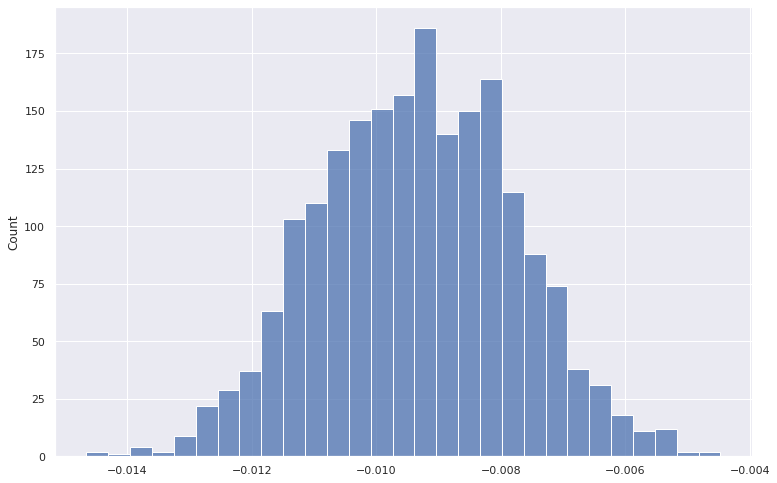

In [46]:
sns.histplot(ctr2 - ctr1)

In [ ]:
Пуассоновский бутстреп показывает нам, что применение новой системы рекомендаций снижает CTR

## Бакетное преобразование

In [50]:
#Разбиваем пользователей на 50 бакетов

q = """
SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group,
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
FROM simulator_20250120.feed_actions
WHERE toDate(time) between '2025-01-03' and '2025-01-09'
and exp_group in (1,2)
GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""
df = pandahouse.read_clickhouse(q, connection=connection)

# Применим T-test
stats.ttest_ind(df[df.exp_group == 1].bucket_ctr,
                   df[df.exp_group == 2].bucket_ctr,
                   equal_var = False)

Ttest_indResult(statistic=5.614819358149381, pvalue=4.592644937473873e-07)

In [52]:
# Применим Манна-Уитни
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr,
                   df[df.exp_group == 2].bucket_ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1997.0, pvalue=2.6576427804010095e-07)

In [ ]:
И Т-тест и тест Манна-Уитни показал наличие статистически значимых различий

<Axes: xlabel='bucket_ctr', ylabel='Count'>

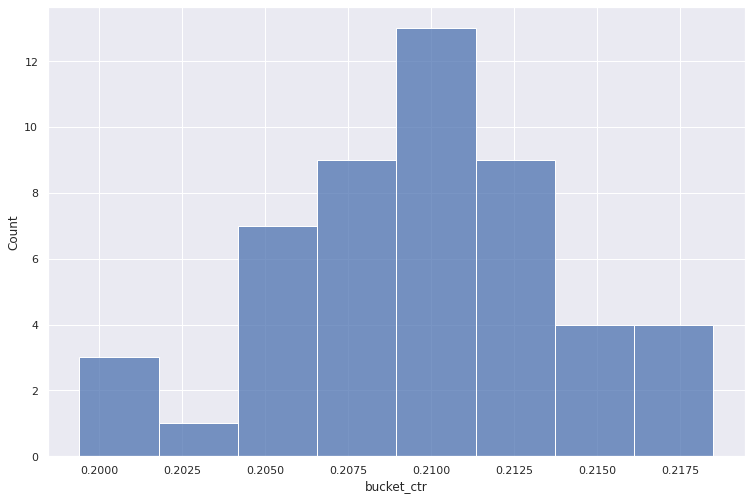

In [56]:
sns.histplot(df[df.exp_group == 1].bucket_ctr)

<Axes: xlabel='bucket_ctr', ylabel='Count'>

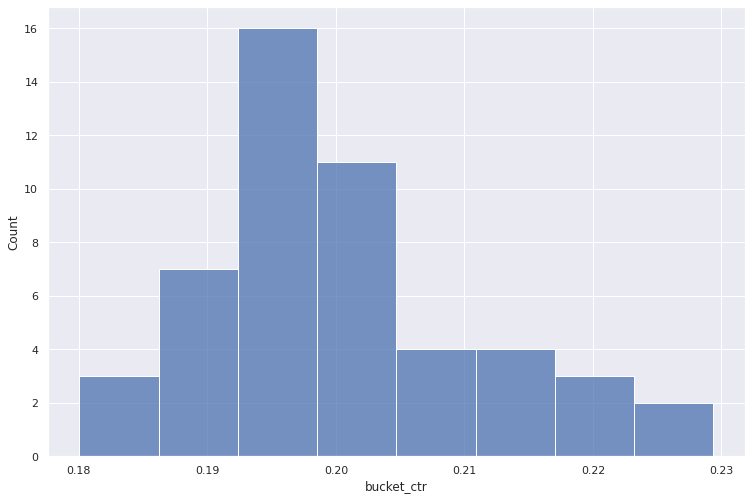

In [57]:
sns.histplot(df[df.exp_group == 2].bucket_ctr)

## Выводы:

По результатам проведенных тестов на группах 1 и 2 видно, что утверждать об эффективности новой системы рекомендаций нельзя.

- Новая система рекомендаций разделяет пользователей на две выраженные группы: для одной большой группы она снижает CTR (эта часть пользователей не любит повторяющийся контент, например),
а для другой, наоборот, повышает (эти пользователи любят лайкать одно и то же)
- Т-тесты не выявили статистически значимые различия между группами, но опираться на этот метод при ненормальном распределении во второй группе не стоит.
- Все остальные примененные тесты (Манна-Уитни, Сглаженный CTR, Пуассоновский бутстреп, Бакетное преобразование) показали снижение CTR в тестовой группе.

Рекомендации:
Раскатывать систему рекомендаций "похожие на лайкнутые посты" на всех пользователей не стоит.
Нужно разобраться почему эта система так повлияла на наших пользователей, провести дополнительную аналитику и выявить почему CTR во второй группе стал бимодальным.
В текущем виде система рекомендаций требует доработки или, возможно, стоит вообще отказаться от нее. 
    
Также есть вероятность, что мы неправильно выбрали группы для тестирования.